In [1]:
import os
import sys
sys.path.append("..")
import phage_init

In [2]:
import numpy
import itertools
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from scipy import stats
from Bio.Alphabet import IUPAC
#from itertools import permutations


In [ ]:
#from numba import jit,vectorize

In [3]:
all_fasta=(os.path.join(phage_init.fasta_dir_2,"major_capsid_all_clustered.fasta"),os.path.join(phage_init.fasta_dir_2,"minor_capsid_all_clustered.fasta"),
           os.path.join(phage_init.fasta_dir_2,"baseplate_all_clustered.fasta"),os.path.join(phage_init.fasta_dir_2,"major_tail_all_clustered.fasta"),
           os.path.join(phage_init.fasta_dir_2,"minor_tail_all_clustered.fasta"),os.path.join(phage_init.fasta_dir_2,"portal_all_clustered.fasta"),
           os.path.join(phage_init.fasta_dir_2,"tail_fiber_all_clustered.fasta"),os.path.join(phage_init.fasta_dir_2,"shaft_all_clustered.fasta"),
           os.path.join(phage_init.fasta_dir_2,"collar_all_clustered.fasta"),os.path.join(phage_init.fasta_dir_2,"HTJ_all_clustered.fasta"),
           os.path.join(phage_init.fasta_dir_2,"others_all_clustered.fasta"))

In [4]:

def extract_all2(fasta_list):
    AA=["A","C","D","E","F","G","H","I","K","L","M","N","P","Q","R","S","T","V","W","Y"]
    di_pep = [''.join(i) for i in itertools.product(AA, repeat = 2)]
    AAs=set(AA)
    prot_class=0;
    arr = numpy.empty((0,408), dtype=numpy.float)
    class_arr = numpy.empty((0), dtype=numpy.int)
    for file in fasta_list:
        print('####################' + file)
        for record in SeqIO.parse(file, "fasta"):
            ll=len(record.seq)
            seqq=record.seq.__str__().upper()
            seqqq=seqq.replace('X','A').replace('J','L').replace('*','A').replace('Z','E').replace('B','D')
            X = ProteinAnalysis(seqqq)
#            if (bool(set(seqqq)-AAs)):
#                print(record.description)
#                print(seqqq)
            tt= [X.isoelectric_point(), X.instability_index(),ll,X.aromaticity(),
                X.molar_extinction_coefficient()[0],X.molar_extinction_coefficient()[1],
                X.gravy(),X.molecular_weight()]
            tt_n = numpy.asarray(tt,dtype=numpy.float)
            
            di_pep_count=[seqq.count(i)/(ll-1) for i in di_pep]
            di_pep_count_n = numpy.asarray(di_pep_count,dtype=numpy.float)
    
            cat_n= numpy.concatenate((di_pep_count_n,tt_n))
            #print(cat_n.shape)
            cat_n = cat_n.reshape((1,cat_n.shape[0]))

            arr = numpy.append(arr,cat_n , axis=0)
            class_arr = numpy.append(class_arr,prot_class)
        prot_class+=1
    return (arr,class_arr)
    

In [5]:
(arr,class_arr)=extract_all2(all_fasta)
print(arr.shape)

####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/major_capsid_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/minor_capsid_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/baseplate_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/major_tail_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/minor_tail_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/portal_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/tail_fiber_all_clustered.fasta
####################/home/adrian/git-presentations/keras/phage_protein/download_seq/all/clustered/

In [6]:
print(arr.shape)

(220483, 408)


In [7]:

arr_z=numpy.apply_along_axis(stats.zscore,0,arr)



In [8]:
nb_classes = 11
one_hot_targets = numpy.eye(nb_classes)[class_arr]

In [9]:
final = numpy.concatenate((arr_z, one_hot_targets), axis=1)

In [10]:
mean_arr=numpy.apply_along_axis(numpy.mean,0,arr)
#print(mean_arr)
print(mean_arr.shape)
std_arr=numpy.apply_along_axis(numpy.std,0,arr)
print(std_arr.shape)

(408,)
(408,)


In [11]:
numpy.random.shuffle(final)

In [21]:
import pickle
##number of proteins for training

##number of features
print(final.shape[1])
pickle.dump(final, open( os.path.join(phage_init.data_dir,"data2_plus_others_final.p"), "wb" ) )
#pickle.dump(final[tt:,0:f_num],  open( os.path.join(phage_init.data_dir,"test_x_data2.p") , "wb" ) )
#pickle.dump(final[0:tt,f_num:], open( os.path.join(phage_init.data_dir,"train_y_data2.p"), "wb" ) )
#pickle.dump(final[tt:,f_num:],  open( os.path.join(phage_init.data_dir,"test_y_data2.p") , "wb" ) )
#pickle.dump(mean_arr,  open( os.path.join(phage_init.data_dir,"mean_data2.p") , "wb" ) )
#pickle.dump(std_arr,  open( os.path.join(phage_init.data_dir,"std_data2.p") , "wb" ) )

419


In [ ]:
final=pickle.load(open( os.path.join(phage_init.data_dir,"data2_plus_others_final.p"), "rb" ) )

In [22]:
tt=200000  
f_num=final.shape[1]-11
train_X=final[0:tt,0:f_num]
train_Y=final[0:tt,f_num:]
test_X=final[tt:,0:f_num]
test_Y=final[tt:,f_num:]
            

In [16]:
#import keras and numpy
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [17]:
#this list the devices, just making sure there is a GPU present, you might be fine with no GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14598369932266035028
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17984589683284357420
physical_device_desc: "device: XLA_CPU device"
]


In [72]:
model = Sequential()
#lr normally 0.001
opt=Adam(lr=0.004, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.add(Dense(f_num, input_dim=f_num, kernel_initializer='random_uniform',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200,activation='relu'))
#model.add(Dense(200,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(200,activation='relu'))
#model.add(Dense(200,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(11,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 408)               166872    
_________________________________________________________________
dropout_22 (Dropout)         (None, 408)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 200)               81800     
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 11)                2211      
Total para

In [51]:
from collections import Counter
train_Y_index = train_Y.argmax(axis=1)
train_count=Counter(train_Y_index)
train_w_temp=[tt/train_count[i] for i in range(0,11,1)]
train_weights = dict(zip(range(0,11,1),sample_w_i) )
print(train_weights)

{0: 0.0008038585209003215, 1: 0.016129032258064516, 2: 0.005128205128205128, 3: 0.003367003367003367, 4: 0.0026954177897574125, 5: 0.0005973715651135006, 6: 0.003355704697986577, 7: 0.00211864406779661, 8: 0.00847457627118644, 9: 0.001692047377326565, 10: 6.595870984763538e-05}


In [57]:
model.fit(train_X, train_Y, epochs=200,verbose=1, batch_size=5000,class_weight=train_weights)

Epoch 1/200
200000/200000 [==============================] - 8s 38us/step - loss: 3.5917e-05 - acc: 0.9184
Epoch 2/200
200000/200000 [==============================] - 7s 36us/step - loss: 3.4994e-05 - acc: 0.9209
Epoch 3/200
200000/200000 [==============================] - 7s 35us/step - loss: 3.6495e-05 - acc: 0.9172
Epoch 4/200
200000/200000 [==============================] - 7s 35us/step - loss: 3.6721e-05 - acc: 0.9163
Epoch 5/200
200000/200000 [==============================] - 8s 38us/step - loss: 3.5319e-05 - acc: 0.9211
Epoch 6/200
200000/200000 [==============================] - 7s 35us/step - loss: 3.4447e-05 - acc: 0.9235
Epoch 7/200
200000/200000 [==============================] - 8s 39us/step - loss: 3.5665e-05 - acc: 0.9218
Epoch 8/200
200000/200000 [==============================] - 7s 37us/step - loss: 3.5288e-05 - acc: 0.9245
Epoch 9/200
200000/200000 [==============================] - 7s 36us/step - loss: 3.4615e-05 - acc: 0.9245
Epoch 10/200
200000/200000 [=========

200000/200000 [==============================] - 7s 36us/step - loss: 2.5071e-05 - acc: 0.9515
Epoch 152/200
200000/200000 [==============================] - 7s 35us/step - loss: 2.5600e-05 - acc: 0.9496
Epoch 153/200
200000/200000 [==============================] - 7s 37us/step - loss: 2.6891e-05 - acc: 0.9507
Epoch 154/200
200000/200000 [==============================] - 7s 35us/step - loss: 2.5750e-05 - acc: 0.9497
Epoch 155/200
200000/200000 [==============================] - 8s 38us/step - loss: 2.7061e-05 - acc: 0.9509
Epoch 156/200
200000/200000 [==============================] - 7s 37us/step - loss: 2.5818e-05 - acc: 0.9493
Epoch 157/200
200000/200000 [==============================] - 7s 37us/step - loss: 2.4002e-05 - acc: 0.9498
Epoch 158/200
200000/200000 [==============================] - 7s 34us/step - loss: 2.6251e-05 - acc: 0.9494
Epoch 159/200
200000/200000 [==============================] - 7s 34us/step - loss: 2.4637e-05 - acc: 0.9504
Epoch 160/200
200000/200000 [====

In [58]:
scores = model.evaluate(test_X, test_Y, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

20483/20483 [==============================] - 2s 86us/step
Accuracy: 92.38%


In [59]:
from sklearn.metrics import classification_report


test_Y_index = test_Y.argmax(axis=1) # Convert one-hot to index
test_Y_predicted = model.predict_classes(test_X)
labels_names=["Major capsid","Minor capsid","Baseplate","Major tail","Minor tail","Portal","Tail fiber",
             "Tail shaft","Collar","Head-Tail joining","Other"]
print(classification_report(test_Y_index, test_Y_predicted, target_names=labels_names ))

                   precision    recall  f1-score   support

     Major capsid       0.87      0.91      0.89      1244
     Minor capsid       0.52      0.56      0.54        62
        Baseplate       0.71      0.85      0.77       195
       Major tail       0.79      0.90      0.84       297
       Minor tail       0.70      0.81      0.75       371
           Portal       0.87      0.91      0.89      1674
       Tail fiber       0.54      0.66      0.59       298
       Tail shaft       0.90      0.96      0.93       472
           Collar       0.75      0.77      0.76       118
Head-Tail joining       0.72      0.86      0.78       591
            Other       0.97      0.94      0.96     15161

        micro avg       0.92      0.92      0.92     20483
        macro avg       0.76      0.83      0.79     20483
     weighted avg       0.93      0.92      0.93     20483



In [55]:
from collections import Counter
zz=Counter(test_Y_index)
sample_w=[zz[i] for i in range(0,11,1)]
sample_w_i=[1/zz[i] for i in range(0,11,1)]
dictionary = dict(zip(range(0,11,1),sample_w_i) )
print(zz)
print(sample_w)
print(dictionary)

Counter({10: 15161, 5: 1674, 0: 1244, 9: 591, 7: 472, 4: 371, 6: 298, 3: 297, 2: 195, 8: 118, 1: 62})
[1244, 62, 195, 297, 371, 1674, 298, 472, 118, 591, 15161]
{0: 0.0008038585209003215, 1: 0.016129032258064516, 2: 0.005128205128205128, 3: 0.003367003367003367, 4: 0.0026954177897574125, 5: 0.0005973715651135006, 6: 0.003355704697986577, 7: 0.00211864406779661, 8: 0.00847457627118644, 9: 0.001692047377326565, 10: 6.595870984763538e-05}


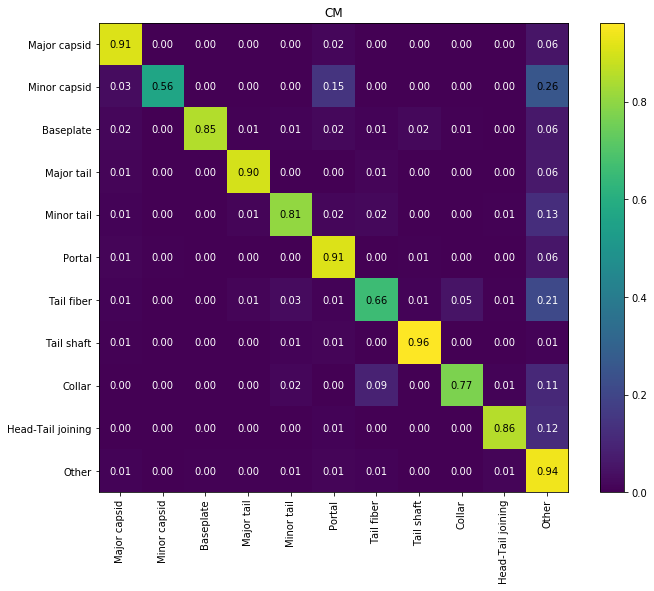

In [79]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

CM=confusion_matrix(test_Y_index, test_Y_predicted)
CM_n=CM/numpy.array(sample_w)[:,None]
scale_up=1.8
plt.figure(figsize=[6.4*scale_up, 4.8*scale_up])
plt.imshow(CM_n, interpolation='nearest')
plt.title('CM')
plt.colorbar()
tick_marks = numpy.arange(len(labels_names))
plt.xticks(tick_marks, labels_names, rotation=90)
plt.yticks(tick_marks, labels_names)
fmt = '.2f'
for i, j in itertools.product(range(CM_n.shape[0]), range(CM_n.shape[1])):
        plt.text(j, i, format(CM_n[i, j], fmt),horizontalalignment="center",verticalalignment='center',
                color="white" if CM_n[i, j] < 0.25 else "black")
plt.show()

In [66]:
train_Y_2class_tmp=[1 if x==10 else 0 for x in train_Y_index]
train_Y_2class = numpy.eye(2)[train_Y_2class_tmp]
test_Y_2class_tmp=[1 if x==10 else 0 for x in test_Y_index]
test_Y_2class = numpy.eye(2)[test_Y_2class_tmp]
#print(train_Y_2class)

In [73]:
model2 = Sequential()
#lr normally 0.001
opt=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.add(Dense(f_num, input_dim=f_num, kernel_initializer='random_uniform',activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(200,activation='relu'))
#model.add(Dense(200,activation='sigmoid'))
model2.add(Dropout(0.2))
model2.add(Dense(200,activation='relu'))
#model.add(Dense(200,activation='sigmoid'))
model2.add(Dropout(0.2))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 408)               166872    
_________________________________________________________________
dropout_25 (Dropout)         (None, 408)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 200)               81800     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 402       
Total para

In [75]:
model2.fit(train_X, train_Y_2class, epochs=50,verbose=1, batch_size=5000)

Epoch 1/50
200000/200000 [==============================] - 8s 38us/step - loss: 0.1058 - acc: 0.9602
Epoch 2/50
200000/200000 [==============================] - 8s 41us/step - loss: 0.0971 - acc: 0.9632
Epoch 3/50
200000/200000 [==============================] - 8s 40us/step - loss: 0.0889 - acc: 0.9660
Epoch 4/50
200000/200000 [==============================] - 8s 39us/step - loss: 0.0822 - acc: 0.9689
Epoch 5/50
200000/200000 [==============================] - 8s 38us/step - loss: 0.0763 - acc: 0.9716
Epoch 6/50
200000/200000 [==============================] - 8s 39us/step - loss: 0.0715 - acc: 0.9729
Epoch 7/50
200000/200000 [==============================] - 8s 40us/step - loss: 0.0675 - acc: 0.9747
Epoch 8/50
200000/200000 [==============================] - 8s 39us/step - loss: 0.0630 - acc: 0.9761
Epoch 9/50
200000/200000 [==============================] - 8s 40us/step - loss: 0.0596 - acc: 0.9774
Epoch 10/50
200000/200000 [==============================] - 7s 36us/step - loss: 

In [76]:
scores = model2.evaluate(test_X, test_Y_2class, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

20483/20483 [==============================] - 2s 102us/step
Accuracy: 94.26%


In [77]:
#test_Y_index = test_Y.argmax(axis=1) # Convert one-hot to index
test_Y_2class_predicted = model2.predict_classes(test_X)

print(classification_report(test_Y_2class_tmp,test_Y_2class_predicted , target_names=["structural","other"]))

              precision    recall  f1-score   support

  structural       0.89      0.89      0.89      5322
       other       0.96      0.96      0.96     15161

   micro avg       0.94      0.94      0.94     20483
   macro avg       0.93      0.93      0.93     20483
weighted avg       0.94      0.94      0.94     20483



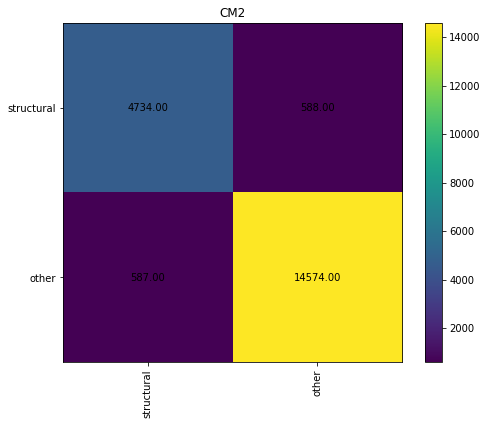

In [78]:
CM2=confusion_matrix(test_Y_2class_tmp,test_Y_2class_predicted )
#CM_n=CM/numpy.array(sample_w)[:,None]
scale_up=1.3
plt.figure(figsize=[6.4*scale_up, 4.8*scale_up])
plt.imshow(CM2, interpolation='nearest')
plt.title('CM2')
plt.colorbar()
tick_marks = numpy.arange(2)
plt.xticks(tick_marks, ["structural","other"], rotation=90)
plt.yticks(tick_marks, ["structural","other"])
fmt = '.2f'
for i, j in itertools.product(range(CM2.shape[0]), range(CM2.shape[1])):
        plt.text(j, i, format(CM2[i, j], fmt),horizontalalignment="center",verticalalignment='center',
                color="white" if CM2[i, j] < 0.25 else "black")
plt.show()